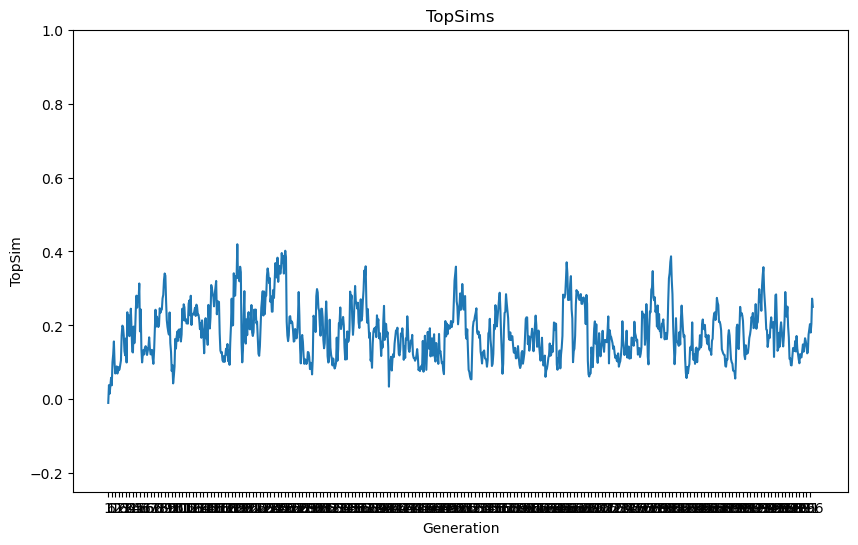

グラフを保存しました: out/exp20241002_201835/topsim_transition.png
最終世代の発話: ['S/_kick(_alice,_bob)/0->hijaaqg', 'S/_kick(_alice,_carol)/0->mzjmao', 'S/_kick(_alice,_david)/0->ghua', 'S/_kick(_alice,_eve)/0->zttto', 'S/_kick(_bob,_alice)/0->gqeijmaw', 'S/_kick(_bob,_carol)/0->cbwz', 'S/_kick(_bob,_david)/0->gwua', 'S/_kick(_bob,_eve)/0->guqijmaw', 'S/_kick(_carol,_alice)/0->juzo', 'S/_kick(_carol,_bob)/0->cijaaqg', 'S/_kick(_carol,_david)/0->gcua', 'S/_kick(_carol,_eve)/0->gfk', 'S/_kick(_david,_bob)/0->mijaaqg', 'S/_kick(_david,_carol)/0->oijmaz', 'S/_kick(_david,_eve)/0->lnt', 'S/_kick(_eve,_alice)/0->ghqijqal', 'S/_kick(_eve,_bob)/0->gwqijqal', 'S/_kick(_eve,_carol)/0->gcqijqal', 'S/_kick(_eve,_david)/0->gclf', 'S/_know(_alice,_bob)/0->hijaaag', 'S/_know(_alice,_carol)/0->mrjmao', 'S/_know(_alice,_david)/0->rirgka', 'S/_know(_alice,_eve)/0->avi', 'S/_know(_bob,_alice)/0->geerjmaw', 'S/_know(_bob,_carol)/0->cbwr', 'S/_know(_bob,_david)/0->gmaijmaw', 'S/_know(_bob,_eve)/0->guaijmaw', 'S/_know(_c

In [1]:
import random
import os
from datetime import datetime
from chunk import Chunk
from category_integration import Category_Integration 
from replace import Replace
from production import Production
from topsim import TopSim
from topsim import Visualize_TopSim

class Agent:
    def __init__(self, name, learning_algorithms=None):
        self.name = name
        self.memory = []
        self.meanings_for_production = []
        self.production = []
        self.learning_algorithms = learning_algorithms if learning_algorithms else ['chunk', 'category_integration', 'replace']

    def learn_language(self, rule_set, iterations=3, batch_size=5):
        learned_rules = []
        
        for i in range(0, len(rule_set), batch_size):
            batch = rule_set[i:i + batch_size]
            current_batch = learned_rules + batch

            for _ in range(iterations):
                for algorithm in self.learning_algorithms:
                    if algorithm == 'chunk':
                        current_batch = Chunk.chunk_learning(current_batch)
                    elif algorithm == 'category_integration':
                        current_batch = Category_Integration.category_integration_learning(current_batch)
                    elif algorithm == 'replace':
                        current_batch = Replace.replace_learning(current_batch)

            learned_rules = current_batch

        self.memory = learned_rules

    def produce_language(self, rule_set, all_meanings, holistic_rule_invention_length, word_rule_invention_length, max_form_length, front_keep_length):
        # 全ての意味空間に基づいて発話を生成する
        self.production = Production.produce(
            rule_set, 
            all_meanings,  # ここでは意味空間全体に基づいて発話を行う
            holistic_rule_invention_length, 
            word_rule_invention_length,
            max_form_length, 
            front_keep_length
        )
        return self.production

def sample_meaning_space(file_path):
    """意味空間全体を読み込む"""
    with open(file_path) as f:
        s = f.read()
        meanings = s.split(",\n")
    return meanings

def simulate_language_evolution(
    n_gens, 
    n_samples, 
    initial_language_file, 
    semantic_space_file, 
    holistic_rule_invention_length, 
    word_rule_invention_length, 
    random_seed=1, 
    iterations=3, 
    batch_size=5,
    max_form_length=9,
    front_keep_length=3
):
    # 乱数のシードを設定
    random.seed(random_seed)
    
    parent = Agent(name="Parent")
    child = Agent(name="Child", learning_algorithms=['replace', 'category_integration', 'chunk'])

    now = datetime.now()
    timestamp = now.strftime('%Y%m%d_%H%M%S')
    base_folder = f"out/exp{timestamp}"
    os.makedirs(base_folder, exist_ok=True)
    
    generation_folder = os.path.join(base_folder, "generations")
    os.makedirs(generation_folder, exist_ok=True)

    topsim_values = []

    # 1世代目の親の発話に必要な意味空間全体を取得（初期言語ファイルから）
    all_meanings = sample_meaning_space(file_path=initial_language_file)
    
    # 1世代目の親の発話を生成
    parent.production = parent.produce_language(
        rule_set=[],  # 初期言語ルールがあれば指定する
        all_meanings=all_meanings,
        holistic_rule_invention_length=holistic_rule_invention_length,
        word_rule_invention_length=word_rule_invention_length,
        max_form_length=max_form_length,
        front_keep_length=front_keep_length
    )
    # print(f"世代1の親の発話: {parent.production}")
    with open(os.path.join(generation_folder, "gen-1.txt"), 'w') as f:
        f.write("\n".join(parent.production))

    # 子供に n_samples の学習データを渡す（意味空間全体の中からランダムに選択）
    child_samples = random.sample(parent.production, n_samples)
    # print(f"世代1の子の受け取った発話: {child_samples}")
    child.learn_language(child_samples, iterations=iterations)

    # 全ての発話に対してTopSimを計算
    topsim_value = TopSim.TopSim(parent.production)
    # print(f"世代1の親の発話のTopSim: {parent.production}")
    topsim_values.append(topsim_value)

    # 2世代目以降の処理
    for generation in range(2, n_gens + 1):
        # 2世代目以降の意味空間を全て取得
        all_meanings = sample_meaning_space(file_path=semantic_space_file)

        # 親が意味空間全体に基づいて発話する
        parent.production = parent.produce_language(
            rule_set=child.memory,  # 子供の学習結果が親のルールセットになる
            all_meanings=all_meanings,
            holistic_rule_invention_length=holistic_rule_invention_length,
            word_rule_invention_length=word_rule_invention_length,
            max_form_length=max_form_length,
            front_keep_length=front_keep_length
        )
        # print(f"世代{generation}の親の発話: {parent.production}")
        with open(os.path.join(generation_folder, f"gen-{generation}.txt"), 'w') as f:
            f.write("\n".join(parent.production))

        # 子供に学習データを渡す（n_samplesだけランダムに選ぶ）
        child_samples = random.sample(parent.production, n_samples)
        # print(f"世代{generation}の子の受け取った発話: {child_samples}")
        child.learn_language(child_samples, iterations=iterations)

        # 全発話に対してTopSimを計算
        topsim_value = TopSim.TopSim(parent.production)
        # print(f"世代{generation}の親の発話のTopSim: {parent.production}")
        topsim_values.append(topsim_value)
    
    # TopSimの結果をプロット
    topsim_plot_path = os.path.join(base_folder, "topsim_transition.png")
    Visualize_TopSim.visualize_topsim(topsim_values, len(topsim_values), topsim_plot_path)

    return parent.production, child_samples, child.memory, topsim_values

# 実行部分 (__main__)
if __name__ == "__main__":
    
    for i in range(1): # random_seed
        
        # パラメータ
        N_GENS = 1000  # 世代数
        N_SAMPLES = 40  # 子供が学習するデータ数
        INITIAL_LANGUAGE_FILE = "data/100_3_Initial_Language.txt"  # 1世代目の初期言語ファイル
        SEMANTIC_SPACE_FILE = "data/100_Semantic_Space.txt"  # 2世代目以降の意味空間ファイル
        HOLISTIC_RULE_INVENTION_LENGTH = 3  # 文全体のルールの最大長さ
        WORD_RULE_INVENTION_LENGTH = 1  # 単語ルールの最大長さ
        RANDOM_SEED = i
        ITERATIONS = 3  # 学習アルゴリズムの反復回数
        BATCH_SIZE = 1  # 何個ずつバッチに分けて学習するか
        MAX_FORM_LENGTH = 9  # 形式の最大長さ
        FRONT_KEEP_LENGTH = 6  # 前半に残す長さ

        # シミュレーションの実行
        parent_production, child_samples, child_memory, topsim_values = simulate_language_evolution(
            n_gens=N_GENS, 
            n_samples=N_SAMPLES, 
            initial_language_file=INITIAL_LANGUAGE_FILE, 
            semantic_space_file=SEMANTIC_SPACE_FILE,
            holistic_rule_invention_length=HOLISTIC_RULE_INVENTION_LENGTH,
            word_rule_invention_length=WORD_RULE_INVENTION_LENGTH,
            random_seed=RANDOM_SEED,
            iterations=ITERATIONS,
            batch_size=BATCH_SIZE,
            max_form_length=MAX_FORM_LENGTH,  # 形式の最大長さ
            front_keep_length=FRONT_KEEP_LENGTH  # 前半に残す長さ
        )

        # 結果の表示
        print("最終世代の発話:", parent_production)
        print("最終世代の子供が受け取った発話:", child_samples)
        print("最終世代の子供の記憶:", child_memory)
        print("各世代のTopSim値:", topsim_values)  # 各世代のTopSim値を表示